In [19]:
# Font
import os.path
import matplotlib
import matplotlib.pyplot as plt
import pylab
font = {'family': 'IPAexGothic'}
matplotlib.rc('font', **font)
markerSize = 12
fontSize = 22
figureSize = (12, 9)
bboxPos = (0.5, -0.1)

import numpy as np

from sklearn.linear_model import LogisticRegression

from sklearn import preprocessing
from sklearn import utils

In [20]:
# PNGとEPSファイルを書き出す
def writePNGandEPS(name):
    plt.savefig("%s/%s.png" % ('../../../images/', name))
    plt.savefig("%s/%s.eps" % ('../../../images/', name))

In [21]:
useCache = False

if (useCache):
    learnX = np.load('./sm_learnX.npy')
    learnY = np.load('./sm_learnY.npy')
    learnLabel = np.load('./sm_learnLabel.npy')
    
    testX = np.load('./sm_testX.npy')
    testY = np.load('./sm_testY.npy')
    testLabel = np.load('./sm_testLabel.npy')
    
    x = np.load('./sm_x.npy')
    y = np.load('./sm_y.npy')
    label = np.load('./sm_l.npy')
else:
    dataCount = 100;
    # 0~24の間でランダムにx座標の値を生成する．（時刻データ）
    x = np.sort(np.random.random(size=dataCount) * 24).reshape(-1, 1)
    yWithoutNoise = np.sin(x*np.pi/12);
    # xに対するsin関数の値に，正規分布に従うノイズを足し合わせ，ベースの数値を作る．
    y = yWithoutNoise + 0.1 * np.random.randn(dataCount).reshape(-1, 1)

    # ラベルを切り分ける閾値
    threshold1 = 0.6
    threshold2 = -0.6

    # ラベルデータを閾値から作る
    label = np.ones([dataCount,1])
    label[np.where(y > threshold1)] = 2;
    label[np.where(y < threshold2)] = 0;
    label = label.astype(np.int)

    # ここまでがデータの生成．データを教師データとテストデータに，ランダムで切り分ける．
    # テストデータは，学習に使ってはならない．
    learnIndex = np.random.permutation(dataCount)[0:dataCount/2]
    testIndex = np.random.permutation(dataCount)[dataCount/2:dataCount]

    # 3次の多項式の基底を考えて，xの値を拡張する
    X = np.c_[x, x * x, x * x * x]

    # データを実際に切り分ける
    learnX = X[learnIndex]
    learnY = y[learnIndex]
    learnLabel = label[learnIndex]

    testX = X[testIndex]
    testY = y[testIndex]
    testLabel = label[testIndex]
    
    np.save('./sm_learnX.npy', learnX)
    np.save('./sm_learnY.npy', learnY)
    np.save('./sm_learnLabel.npy', learnLabel)
    
    np.save('./sm_testX.npy', testX)
    np.save('./sm_testY.npy', testY)
    np.save('./sm_testLabel.npy', testLabel)
    
    np.save('./sm_x.npy', x)
    np.save('./sm_y.npy', y)
    np.save('./sm_l.npy', label)

In [22]:
# 書籍用のテキストの書き出し
t = x[10:25,0]
l = label[10:25,0]

for var in range(0, 10):
    print '|%f|%d|' % (t[var], l[var])
    
for var in range(0, 10):
    if l[var]==0:
        print '|%d:%02d|%s|' % (np.floor(t[var]), (t[var] - np.floor(t[var])) * 60, u'メニュー１')
    if l[var]==1:
        print '|%d:%02d|%s|' % (np.floor(t[var]), (t[var] - np.floor(t[var])) * 60, u'メニュー２')
    if l[var]==2:
        print '|%d:%02d|%s|' % (np.floor(t[var]), (t[var] - np.floor(t[var])) * 60, u'メニュー３')

|2.869372|2|
|3.426076|2|
|3.781548|1|
|3.861616|2|
|5.460765|2|
|5.528204|2|
|5.867320|2|
|6.025361|2|
|6.038089|2|
|6.228577|2|
|2:52|メニュー３|
|3:25|メニュー３|
|3:46|メニュー２|
|3:51|メニュー３|
|5:27|メニュー３|
|5:31|メニュー３|
|5:52|メニュー３|
|6:01|メニュー３|
|6:02|メニュー３|
|6:13|メニュー３|


In [23]:
# 学習
log_model = LogisticRegression()
log_model.fit(learnX, learnLabel)

# 性能評価
print(u'学習性能 = %f' % log_model.score(learnX, learnLabel))
print(u'汎化性能 = %f' % log_model.score(testX, testLabel))

# 自前のコードで推論
f = np.dot(log_model.coef_, testX.transpose()) + np.matlib.repmat(log_model.intercept_, 50, 1).transpose()
numerator = np.exp(f)
denominator = np.sum(numerator, axis=0)
p = numerator / denominator
predict = p.transpose().argmax(axis=1)-1

# scikit-learnで推論
predictByScikit = log_model.predict(testX)

学習性能 = 0.860000
汎化性能 = 0.880000


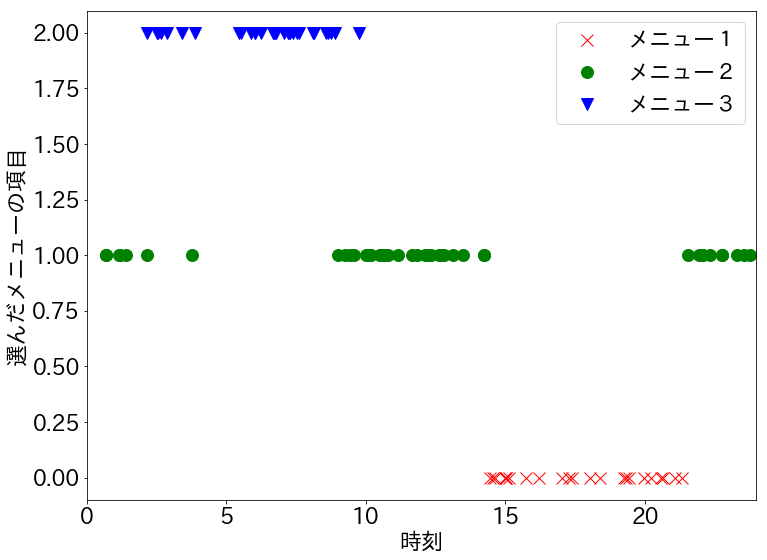

In [28]:
# 描画
index = np.where(label == 0);
pylab.figure(figsize=figureSize)
plt.plot(x[index[0]], np.zeros(index[0].shape), 'rx', label=u'メニュー１', markersize=markerSize)
index = np.where(label == 1);
plt.plot(x[index[0]], np.ones(index[0].shape), 'go', label=u'メニュー２', markersize=markerSize)
index = np.where(label == 2);
plt.plot(x[index[0]], np.ones(index[0].shape)*2, 'bv', label=u'メニュー３', markersize=markerSize)
plt.legend()
plt.ylabel(u'選んだメニューの項目')
plt.xlabel(u'時刻')
plt.xlim(0,24)
plt.rcParams["font.size"] = fontSize
writePNGandEPS('logistic01')
plt.show()

In [29]:
# 過学習のテスト
def testOverfitting(k):
    # 4次の多項式の基底を考えて，xの値を拡張する
    X = np.c_[x]
    for i in range(0, k):
        X = np.c_[X, np.power(x, i+1)]

    # データを実際に切り分ける
    learnX = X[learnIndex]
    learnY = y[learnIndex]
    learnLabel = label[learnIndex]

    testX = X[testIndex]
    testY = y[testIndex]
    testLabel = label[testIndex]

    # 学習
    log_model = LogisticRegression()
    log_model.fit(learnX, learnLabel)

    # 性能評価
    print(u'%d次の多項式を使った場合' % k)
    print(u' ->学習性能 = %f' % log_model.score(learnX, learnLabel))
    print(u' ->汎化性能 = %f' % log_model.score(testX, testLabel))

testOverfitting(1)
testOverfitting(2)
testOverfitting(3)
testOverfitting(4)
testOverfitting(5)
testOverfitting(6)
testOverfitting(7)
testOverfitting(8)
testOverfitting(9)
testOverfitting(16)

1次の多項式を使った場合
 ->学習性能 = 0.620000
 ->汎化性能 = 0.520000
2次の多項式を使った場合
 ->学習性能 = 0.900000
 ->汎化性能 = 0.860000
3次の多項式を使った場合
 ->学習性能 = 0.820000
 ->汎化性能 = 0.860000
4次の多項式を使った場合
 ->学習性能 = 0.860000
 ->汎化性能 = 0.940000
5次の多項式を使った場合
 ->学習性能 = 0.860000
 ->汎化性能 = 0.940000
6次の多項式を使った場合
 ->学習性能 = 0.940000
 ->汎化性能 = 0.980000
7次の多項式を使った場合
 ->学習性能 = 0.960000
 ->汎化性能 = 1.000000
8次の多項式を使った場合
 ->学習性能 = 0.760000
 ->汎化性能 = 0.700000
9次の多項式を使った場合
 ->学習性能 = 0.760000
 ->汎化性能 = 0.700000
16次の多項式を使った場合
 ->学習性能 = 0.360000
 ->汎化性能 = 0.360000


 ->学習性能 = 0.900000
 ->汎化性能 = 0.860000
[-1.6072947   0.29566333 -1.30902006]
[[-0.09512132 -0.09512132  0.01881416]
 [-0.0123587  -0.0123587  -0.00172273]
 [ 0.65390946  0.65390946 -0.127269  ]]


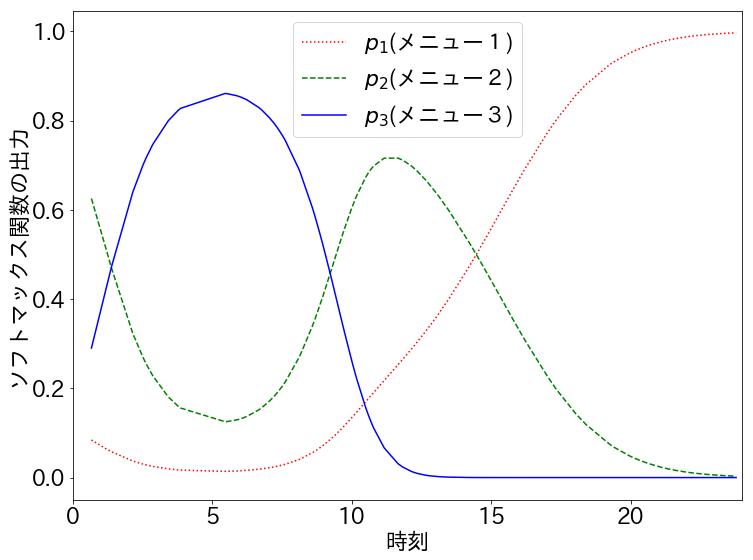

In [30]:
# ソフトマックス関数のレンダリング
k = 3
X = np.c_[x]
for i in range(0, k-1):
    X = np.c_[X, np.power(x, i+1)]

# データを実際に切り分ける
learnX = X[learnIndex]
learnY = y[learnIndex]
learnLabel = label[learnIndex]

testX = X[testIndex]
testY = y[testIndex]
testLabel = label[testIndex]

# 学習
log_model = LogisticRegression()
log_model.fit(learnX, learnLabel)

# 性能評価
print(u' ->学習性能 = %f' % log_model.score(learnX, learnLabel))
print(u' ->汎化性能 = %f' % log_model.score(testX, testLabel))

# 学習したパラメータ
print(log_model.intercept_)
print(log_model.coef_)

# 自前のコードで推論
f = np.dot(log_model.coef_, X.transpose()) + np.matlib.repmat(log_model.intercept_, 100, 1).transpose()
numerator = np.exp(f)

denominator = np.sum(numerator, axis=0)
p = numerator / denominator
predict = p.transpose().argmax(axis=1)-1

# scikit-learnで推論
predictByScikit = log_model.predict(X)

pylab.figure(figsize=figureSize)
plt.plot(x, p[0,:], 'r:', markersize=markerSize, label=u'$p_1$(メニュー１)')
plt.plot(x, p[1,:], 'g--', markersize=markerSize, label=u'$p_2$(メニュー２)')
plt.plot(x, p[2,:], 'b-', markersize=markerSize, label=u'$p_3$(メニュー３)')
plt.legend()
plt.xlabel(u'時刻')
plt.ylabel(u'ソフトマックス関数の出力')
plt.xlim(0,24)
plt.rcParams["font.size"] = fontSize
writePNGandEPS('softmaxResults')
plt.show()

In [27]:
##### CoreML用にモデルとパラメータを書き出す
from coremltools.converters import sklearn  
coreml_model = sklearn.convert(log_model, ["x1", "x2", "x3"], "label")
coreml_model.author = 'Yuichi Yoshida'
coreml_model.license = 'MIT'
coreml_model.short_description = '時刻からよく選ばれるメニューの項目を推定します．'
coreml_model.input_description['x1'] = u'1次の入力値．推定したい値を入力してください．'
coreml_model.input_description['x2'] = u'2次の入力値．推定したい値の2乗を入力してください．'
coreml_model.input_description['x3'] = u'3次の入力値．推定したい値を3乗を入力してください．'
# coreml_model.input_description['x4'] = u'4次の入力値．推定したい値を4乗を入力してください．'
# coreml_model.input_description['x5'] = u'5次の入力値．推定したい値を5乗を入力してください．'
coreml_model.output_description['label'] = u'推定した結果'
coreml_model.save('./MenuPrediction.mlmodel')